In [ ]:
# Target for this task is to try to predict the price of used cars of a public dataset

In [1]:
#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from scipy.stats.mstats import winsorize
import warnings

In [2]:
warnings.filterwarnings("ignore")
cars = pd.read_csv('cars_Spotawheel.csv', names = ['Car_ID', 'Name', 'Year', 'Kilometers_Driven', 'Fuel_Type',
                                                   'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
                                                   'Price'], header=0)
cars.head()

,Car_ID,Name,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,2657,Hyundai i10 Era,2012,60000,Petrol,Manual,Second,19.81 kmpl,1086 CC,68.05 bhp,5.0,2650.0
1,2218,Toyota Fortuner 4x2 Manual,2015,73500,Diesel,Manual,First,13.0 kmpl,2982 CC,168.5 bhp,7.0,22000.0
2,4267,Mercedes-Benz E-Class 230 E AT,2009,28888,Petrol,Automatic,First,10.0 kmpl,2496 CC,157.7 bhp,5.0,7560.0
3,3154,Volkswagen Polo Petrol Trendline 1.2L,2012,41000,Petrol,Manual,First,16.47 kmpl,1198 CC,73.9 bhp,5.0,3100.0
4,4755,Land Rover Range Rover Evoque 2.0 TD4 HSE Dynamic,2016,52000,Diesel,Automatic,First,15.68 kmpl,1999 CC,177 bhp,5.0,42000.0


# Data Preparation

In [3]:
# Base statistics
print(cars.describe(), '\n')

# Check for NaN values
print(cars.isnull().sum(axis = 0))

            Car_ID         Year  Kilometers_Driven        Seats          Price
count  5000.000000  5000.000000        5000.000000  4966.000000    5000.000000
mean   3009.258000  2013.355200       57692.504000     5.275070    9506.900000
std    1736.894449     3.276153       38488.850603     0.805351   11377.444208
min       0.000000  1998.000000         171.000000     0.000000     440.000000
25%    1509.750000  2011.000000       33512.750000     5.000000    3500.000000
50%    3003.500000  2014.000000       53331.000000     5.000000    5630.000000
75%    4510.250000  2016.000000       73000.000000     5.000000    9927.500000
max    6018.000000  2019.000000      775000.000000    10.000000  160000.000000 

Car_ID                0
Name                  0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               1
Engine               28
Power                28
Seats                34
Price                 0

In [4]:
# There is a total number of 5000 car records and just a handfull of rows with missing data
# Going forward we will drop those rows
cars.dropna(inplace=True)

In [5]:
# Create a brand column based on 'Name' column to accumulate for the brand premium on price
brand = cars['Name'].apply(lambda x : x.split(' ')[0])
cars.insert(3,"Brand", brand)
cars.drop(['Name'],axis=1,inplace=True)

# Remove Mileage, Engine and Power measure units
for col in ['Mileage', 'Engine', 'Power']:
    
    col_adj = cars[col].apply(lambda x : x.split()[0])
    cars.drop([col],axis=1,inplace=True)
    cars.insert(3,col, col_adj)

# Remove null values that appear as strings before converting column to numeric type
cars = cars[cars.Power != 'null']
cars[['Mileage', 'Engine', 'Power']] = cars[['Mileage', 'Engine', 'Power']].apply(pd.to_numeric)

print(cars.head())
#Checking for duplicates
print('\n', cars.loc[cars.duplicated()])

   Car_ID  Year          Brand   Power  Engine  Mileage  Kilometers_Driven  \
0    2657  2012        Hyundai   68.05    1086    19.81              60000   
1    2218  2015         Toyota  168.50    2982    13.00              73500   
2    4267  2009  Mercedes-Benz  157.70    2496    10.00              28888   
3    3154  2012     Volkswagen   73.90    1198    16.47              41000   
4    4755  2016           Land  177.00    1999    15.68              52000   

  Fuel_Type Transmission Owner_Type  Seats    Price  
0    Petrol       Manual     Second    5.0   2650.0  
1    Diesel       Manual      First    7.0  22000.0  
2    Petrol    Automatic      First    5.0   7560.0  
3    Petrol       Manual      First    5.0   3100.0  
4    Diesel    Automatic      First    5.0  42000.0  

 Empty DataFrame
Columns: [Car_ID, Year, Brand, Power, Engine, Mileage, Kilometers_Driven, Fuel_Type, Transmission, Owner_Type, Seats, Price]
Index: []


# Data Exploration

In [6]:
cars.set_index('Car_ID', inplace = True)

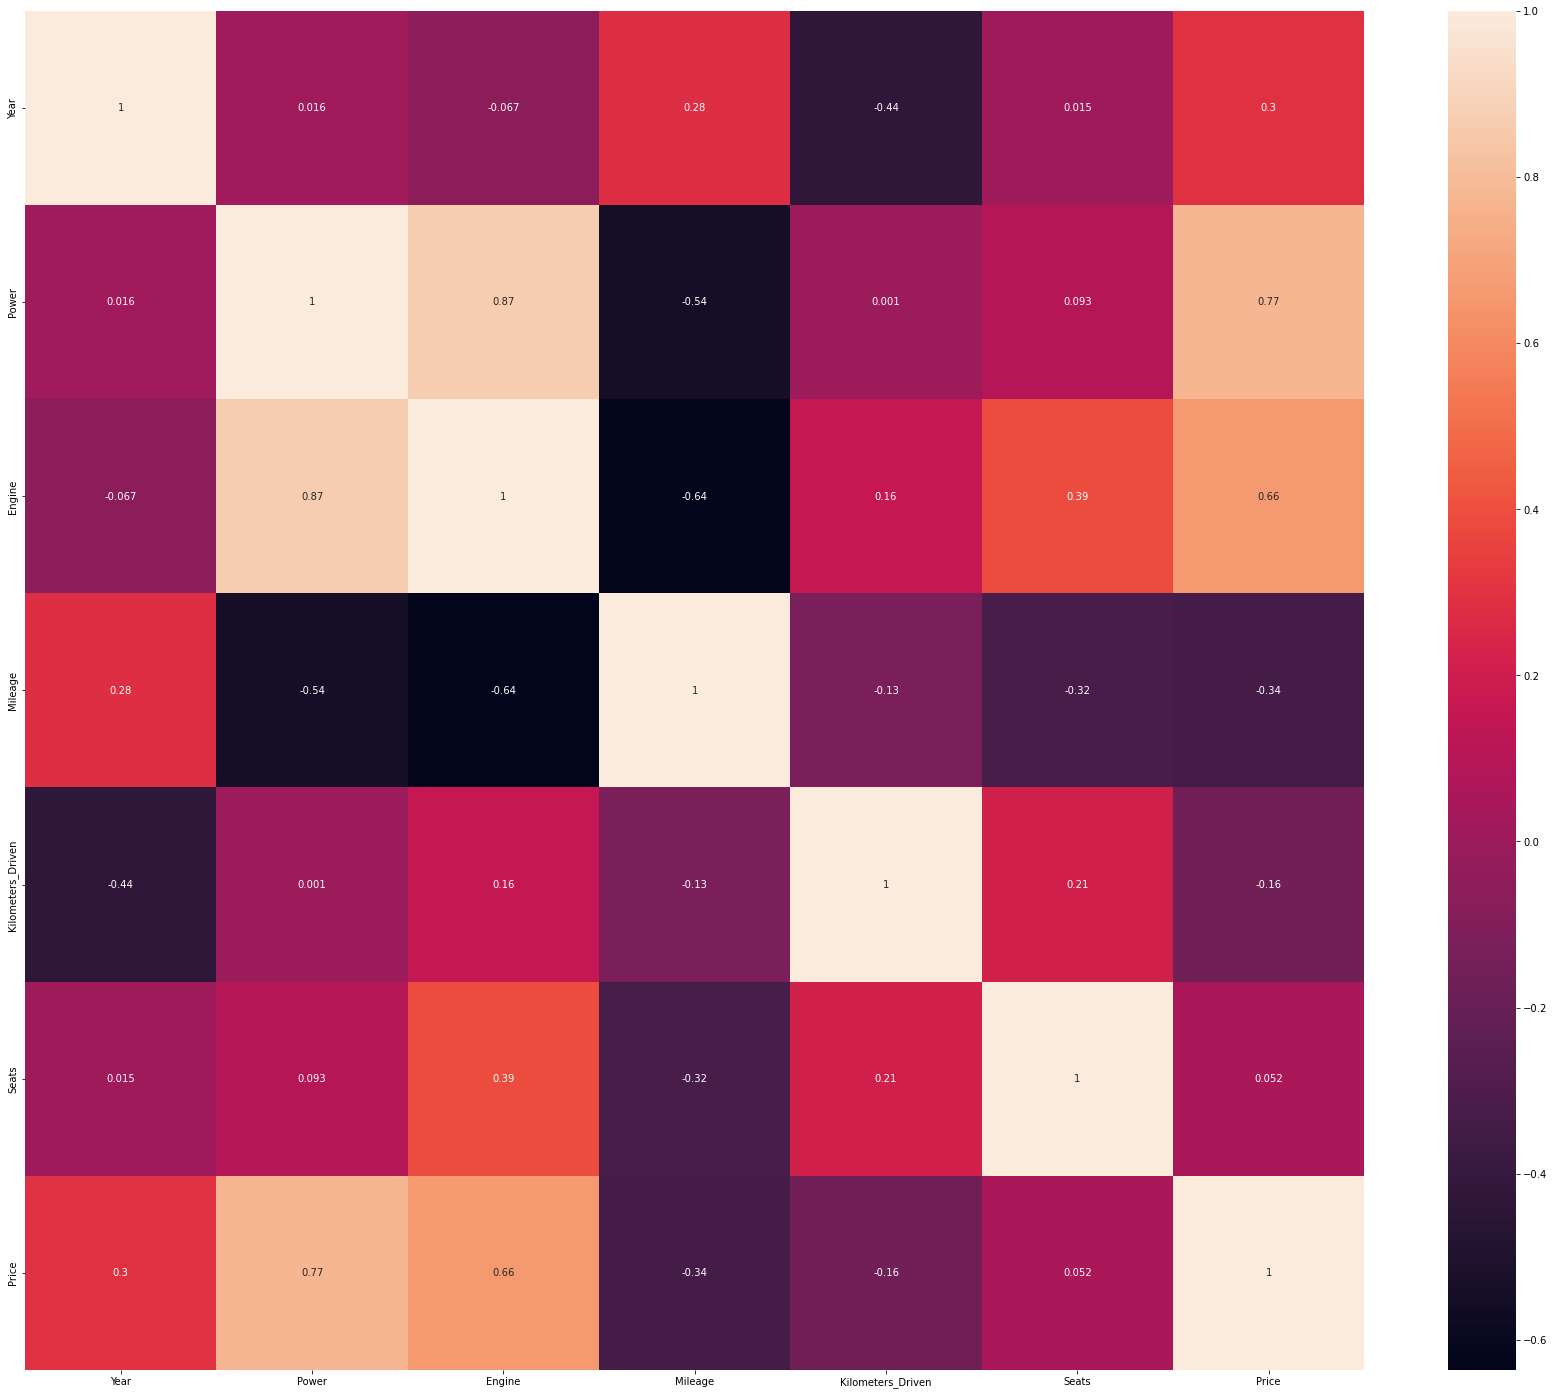

In [7]:
#Correlation plot
plt.figure(figsize = (30, 25))
sns.heatmap(cars.corr(), annot = True)
plt.show()

In [8]:
# As expected at some point there seems to be strong positive correlation between: power & engine, power & price, engine & price
# Negative corellation between engine and mileage

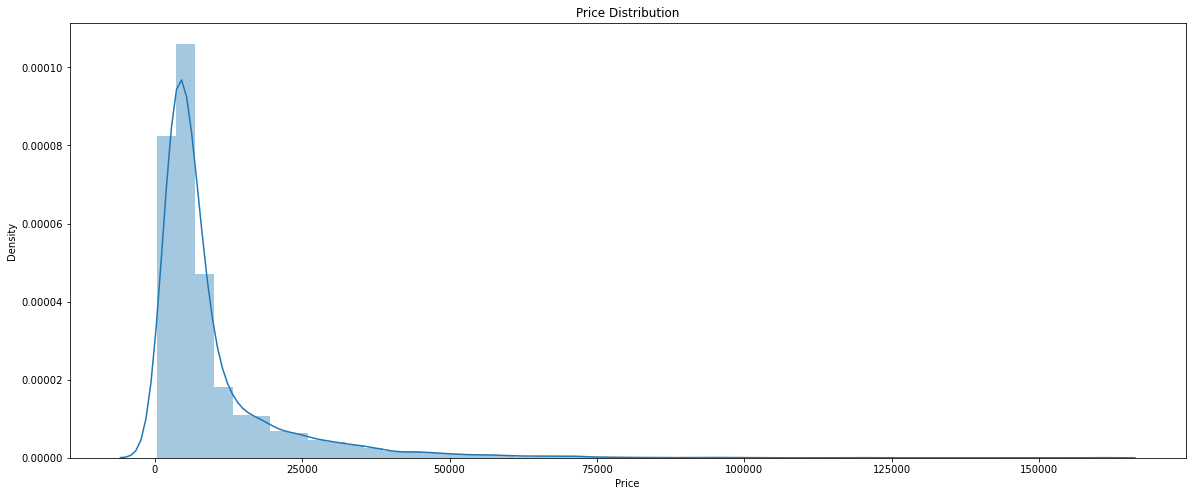

In [9]:
plt.figure(figsize=(20,8))

plt.title('Price Distribution')
sns.distplot(cars.Price)

plt.show()

In [10]:
# Price distribution seems a bit skewed to the right as well meaning that most vehicles have less than 20K of worth

<AxesSubplot:title={'center':'Price Progression'}, xlabel='Year', ylabel='Price'>

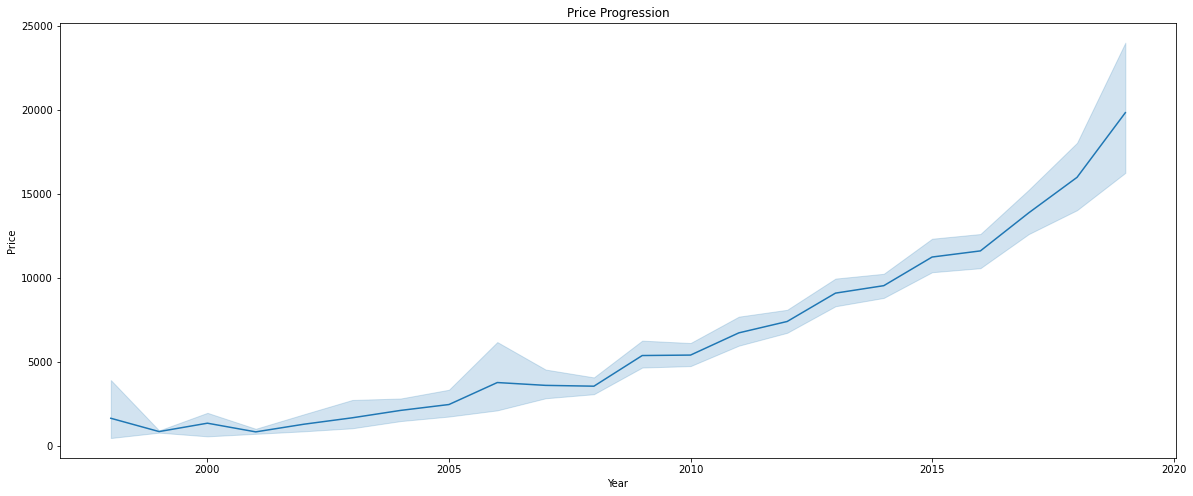

In [11]:
plt.figure(figsize=(20,8))

plt.title('Price Progression')
sns.lineplot(data=cars, x="Year", y="Price")

In [12]:
# It also seems that there is an increase in price in price as years pass by especially after 2010

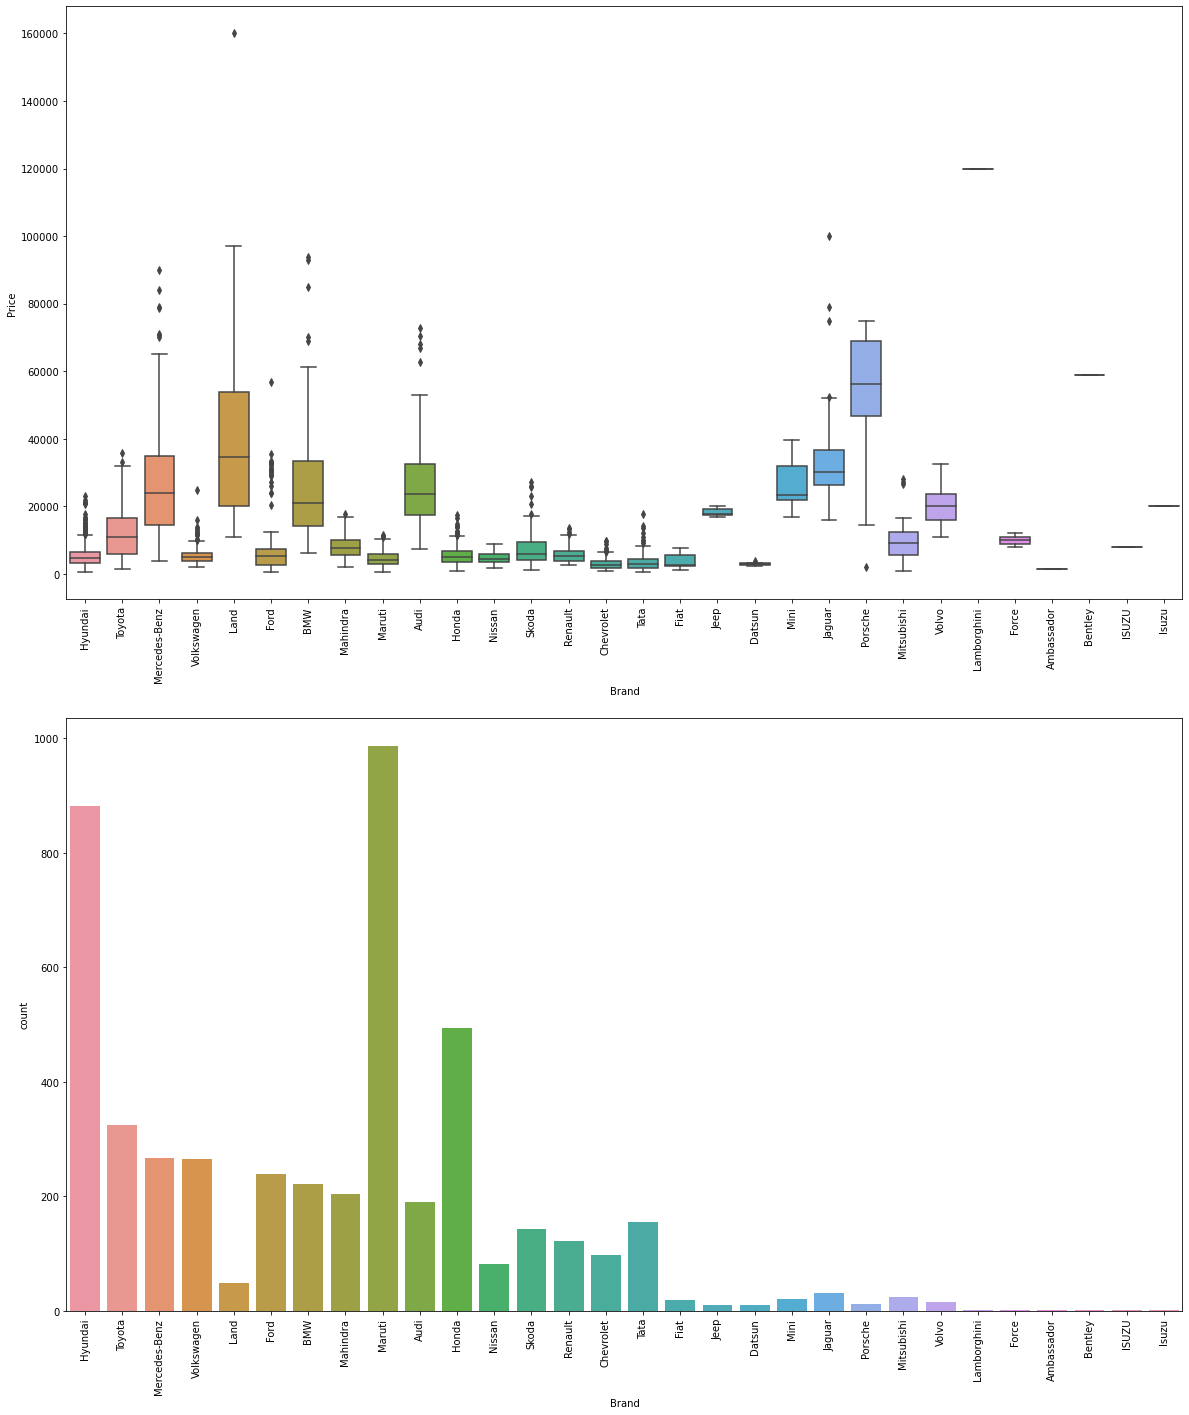

In [13]:
plt.figure(figsize=(20,24))

plt.subplot(2,1,1)
sns.boxplot(x="Brand", y="Price", data=cars)
plt.tick_params(axis='x', rotation=90)
plt.subplot(2,1,2)
sns.countplot(x="Brand", data=cars)
plt.tick_params(axis='x', rotation=90)

In [14]:
# Maruti and Hyundai have the largest share of cars but apparently they are quite cheap

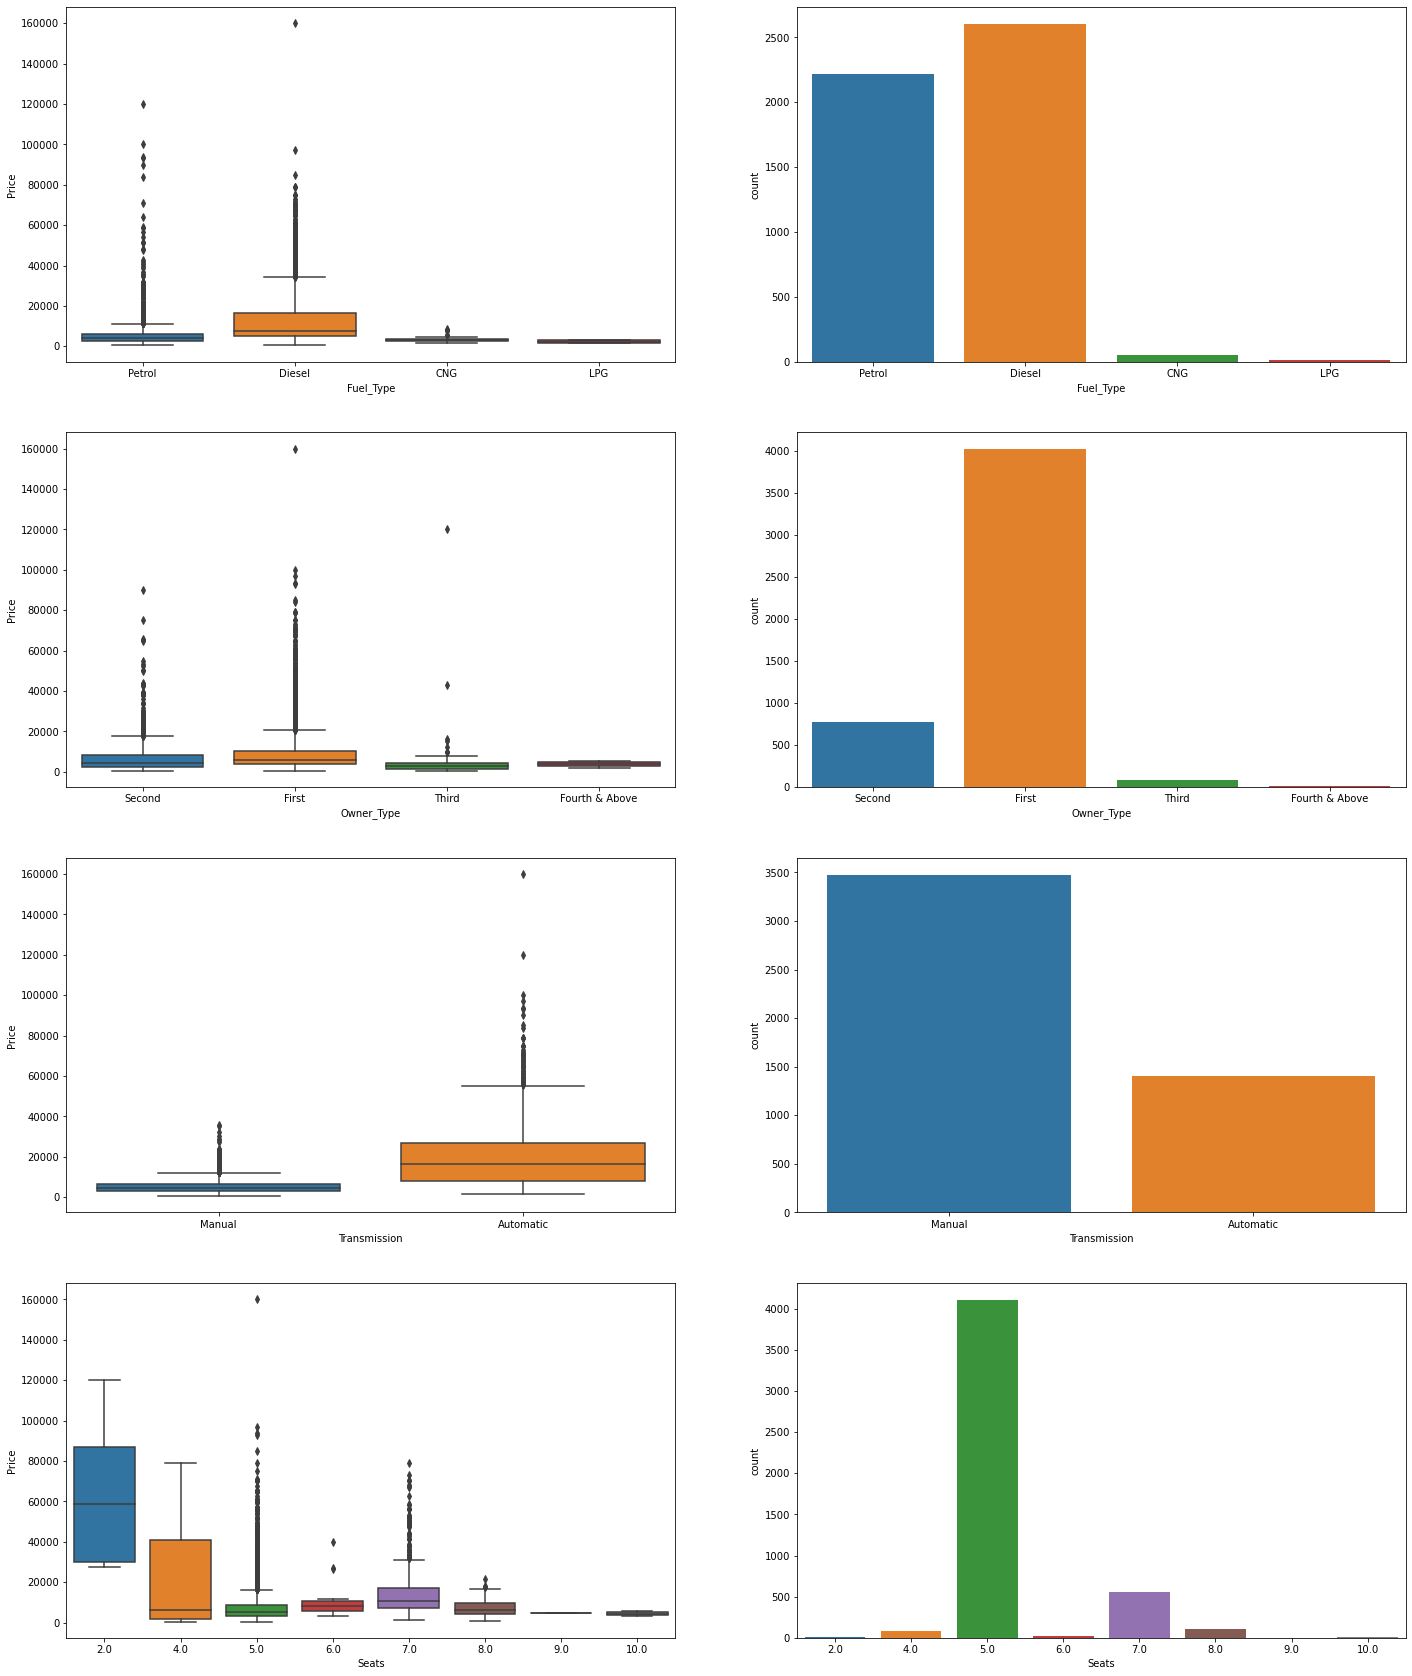

In [15]:
plt.figure(figsize=(24,30))

plt.subplot(4,2,1)
sns.boxplot(x="Fuel_Type", y="Price", data=cars)
plt.subplot(4,2,2)
sns.countplot(x="Fuel_Type", data=cars)

plt.subplot(4,2,3)
sns.boxplot(x="Owner_Type", y="Price", data=cars)
plt.subplot(4,2,4)
sns.countplot(x="Owner_Type", data=cars)

plt.subplot(4,2,5)
sns.boxplot(x="Transmission", y="Price", data=cars)
plt.subplot(4,2,6)
sns.countplot(x="Transmission", data=cars)

plt.subplot(4,2,7)
sns.boxplot(x="Seats", y="Price", data=cars)
plt.subplot(4,2,8)
sns.countplot(x="Seats", data=cars)

plt.show()

In [16]:
# Automatic vehicles are more expensive than manual ones
# Same applies for 2-door cars, although just a bunch of them, which could be explained from the fact that there are a lot sport/high end cars in that category
# Diesel cars seem to be slightly more expensive, perhaps due to fuel economy they offer

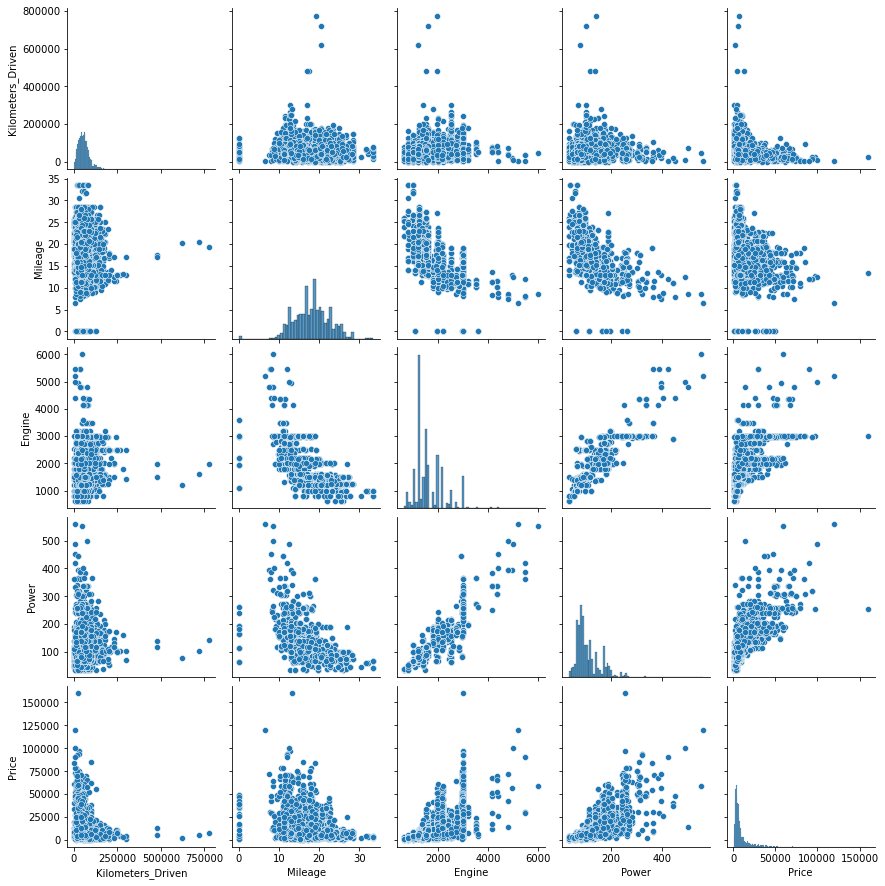

In [17]:
cars_numeric = cars[['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Price']]
cars_numeric.head()
sns.pairplot(cars_numeric)
plt.show()

In [18]:
# Power & engine seem to have a linear relationship with price
# "Weaker" the engine the more miles per litre for the cars
# The more expensive the car, the less kilometers it seems to have
# There also seem to be outliers in the data more spesifically in kilometers driver and mileage

In [19]:
# Winsorize data to replace outliers
for col in ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Price']:

    sorted_col = cars[col].sort_values(ascending = True)
    q1, q3= np.percentile(sorted_col,[25,75])
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr)

    lower_limit = len(sorted_col.loc[lambda x: x<lower_bound])/len(sorted_col)
    upper_limit = len(sorted_col.loc[lambda x: x>upper_bound])/len(sorted_col)

    cars[col] = winsorize(cars[col], limits=[lower_limit, upper_limit])
cars.describe()

,Year,Power,Engine,Mileage,Kilometers_Driven,Seats,Price
count,4880.000000,4880.000000,4880.000000,4880.000000,4880.000000,4880.000000,4880.000000
mean,2013.468852,111.040699,1613.177459,18.310178,55663.984631,5.280328,7799.922131
std,3.179899,46.737504,563.576607,4.218973,30090.324030,0.799738,5800.363308
min,1998.000000,34.200000,624.000000,7.500000,171.000000,2.000000,440.000000
25%,2012.000000,75.000000,1198.000000,15.260000,33000.000000,5.000000,3500.000000
50%,2014.000000,94.680000,1495.000000,18.250000,53000.000000,5.000000,5700.000000
75%,2016.000000,138.100000,1984.000000,21.100000,72466.000000,5.000000,10000.000000
max,2019.000000,231.100000,2999.000000,28.400000,131000.000000,10.000000,19750.000000


# Further Feature Engineering

In [20]:
# Create car age variable
cars['Age'] = 2022-cars['Year']

In [21]:
# Encoding categorical variables
to_be_encoded = ['Brand', 'Fuel_Type', 'Transmission', 'Owner_Type']
cars_encoded = pd.get_dummies(cars, columns = to_be_encoded)

In [22]:
# X -> Predictors, y -> Target 
y = cars_encoded['Price']
features = list(cars_encoded.columns)
features = [e for e in features if e not in ('Price', 'Power', 'Year')]
X = cars_encoded[features]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

#Scaling the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Build

In [23]:
# Try an xgboost model
xgb = XGBRegressor(learning_rate=0.05,
                      max_depth= 5,
                      min_child_weight= 4,
                      silent= 1,
                      subsample= 0.7,
                      colsample_bytree= 0.7,
                      n_estimators=500,
                      verbosity = 0,
                      random_state=356)

selector = RFECV(xgb, step=1, min_features_to_select=1, cv=3, scoring='neg_mean_absolute_error')

#Fit the model, get a rank of the variables, and a matrix of the selected X variables
selector = selector.fit(X_train_scaled, y_train.values)

#Get rank of X model features
rank = selector.ranking_

# Summarize all features
for i in range(X.shape[1]):
    print('\nColumn: %d, Selected %s, Rank: %.3f,' % (i, selector.support_[i], selector.ranking_[i]), 'Name:', X.columns[i])


Column: 0, Selected True, Rank: 1.000, Name: Engine

Column: 1, Selected True, Rank: 1.000, Name: Mileage

Column: 2, Selected True, Rank: 1.000, Name: Kilometers_Driven

Column: 3, Selected True, Rank: 1.000, Name: Seats

Column: 4, Selected True, Rank: 1.000, Name: Age

Column: 5, Selected False, Rank: 4.000, Name: Brand_Ambassador

Column: 6, Selected True, Rank: 1.000, Name: Brand_Audi

Column: 7, Selected True, Rank: 1.000, Name: Brand_BMW

Column: 8, Selected False, Rank: 2.000, Name: Brand_Bentley

Column: 9, Selected True, Rank: 1.000, Name: Brand_Chevrolet

Column: 10, Selected True, Rank: 1.000, Name: Brand_Datsun

Column: 11, Selected True, Rank: 1.000, Name: Brand_Fiat

Column: 12, Selected False, Rank: 3.000, Name: Brand_Force

Column: 13, Selected True, Rank: 1.000, Name: Brand_Ford

Column: 14, Selected True, Rank: 1.000, Name: Brand_Honda

Column: 15, Selected True, Rank: 1.000, Name: Brand_Hyundai

Column: 16, Selected False, Rank: 9.000, Name: Brand_ISUZU

Column: 17

In [24]:
X_rfecv = X.iloc[:, selector.support_]
# Split data into train and test
X_train_rfecv, X_test_rfecv, y_train, y_test = train_test_split(X_rfecv, y, test_size=0.2, random_state=42)  

#Scaling the data
scaler = MinMaxScaler()
X_train_scaled_rfecv = scaler.fit_transform(X_train_rfecv)
X_test_scaled_rfecv = scaler.transform(X_test_rfecv)

# Try an xgboost model
xgb = XGBRegressor(learning_rate=0.05,
                      max_depth= 5,
                      min_child_weight= 4,
                      silent= 1,
                      subsample= 0.7,
                      colsample_bytree= 0.7,
                      n_estimators=500,
                      verbosity = 0,
                      random_state=356)


#Fit the model, get a rank of the variables, and a matrix of the selected X variables
fitted_model = xgb.fit(X_train_scaled_rfecv, y_train.values)


y_pred = fitted_model.predict(X_test_scaled_rfecv)
score = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {score:0.3f}')

scores = cross_val_score(fitted_model, X_train_scaled_rfecv, y_train, scoring = 'r2', cv=3)
print('R-Squared:', scores)

RMSE: 1382.536
R-Squared: [0.93130143 0.92405748 0.93409037]


(528.4952615827389, 25213.26180792089, 528.4952615827389, 25213.26180792089)

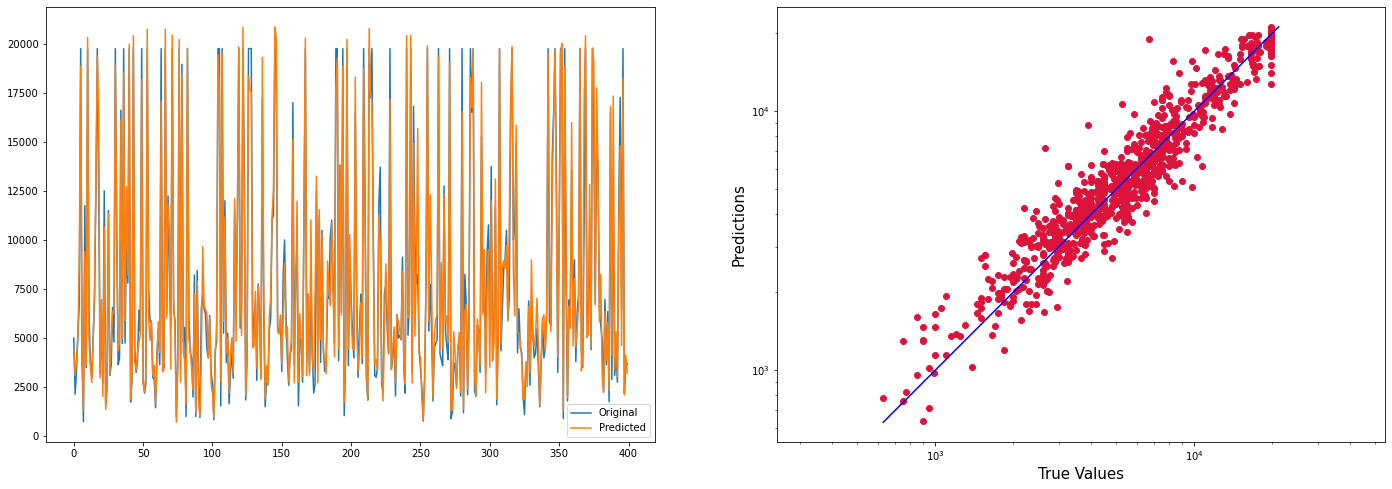

In [27]:
plt.figure(figsize=(24,8))

# Plot first 400 predicted points vs original
plt.subplot(1,2,1)
x_ax = range(len(y_test[:400]))
plt.plot(x_ax, y_test[:400], label="Original")
plt.plot(x_ax, y_pred[:400], label="Predicted")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')

# Next Steps

In [26]:
# Bring in more data. 
# Examples: Average money spent in repairs, taxes associated with model, market indices such as offer & demand
# Hyparameter tuning